### Import Libraries

In [ ]:
import os
import shutil
import random
import numpy as np
import pandas as pd
from PIL import Image, ImageFile
import sys
import cv2
import csv
from tqdm import tqdm
import argparse
import math

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.decomposition import PCA
from torch.utils.tensorboard import SummaryWriter

from torchvision.datasets import CocoDetection
from torchvision.datasets import CIFAR10
from torchvision.datasets import VOCSegmentation
from pycocotools.coco import COCO

from dataset import download_coco_dataset, collate_fn, visualize_segmentation, COCOSegmentation
from model import NasconDino

In [2]:
# Check PyTorch version
print("PyTorch version:", torch.__version__)

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print("CUDA available:", cuda_available)

# If CUDA is available, print CUDA version
if cuda_available:
    print("CUDA version:", torch.version.cuda)

PyTorch version: 2.5.1+cu124
CUDA available: True
CUDA version: 12.4


### Load the COCO Dataset

In [3]:
# Define COCO path
coco_path = "datasets/COCO"
os.makedirs(coco_path, exist_ok=True)

# Download the dataset (if not already downloaded)
download_coco_dataset(coco_path)

### Load Model

In [ ]:
# HYPERPARAMETERS
BATCH_SIZE = 32
image_size = 224

# Select Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

# Initialize the Model
model = NasconDino(pca_components=16).to(device)
print(model)

# Enable loading truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Transformations
image_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
])

# Load the COCO dataset
train_dataset = COCOSegmentation(
    root=f"{coco_path}/train2017",
    annFile=f"{coco_path}/annotations/instances_train2017.json",
    transform=image_transforms,
)
val_dataset = COCOSegmentation(
    root=f"{coco_path}/val2017",
    annFile=f"{coco_path}/annotations/instances_val2017.json",
    transform=image_transforms,
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, collate_fn=collate_fn)
# val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn)

# Check that the dataset is loaded
print(f"Total number of images in train set: {len(train_dataset)}")
# print(f"Total number of images in validation set: {len(val_dataset)}")


device:  cuda


Using cache found in C:\Users\russ_le/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\russ_le/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\russ_le/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\russ_le/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


NasconDino(
  (original_model): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
     

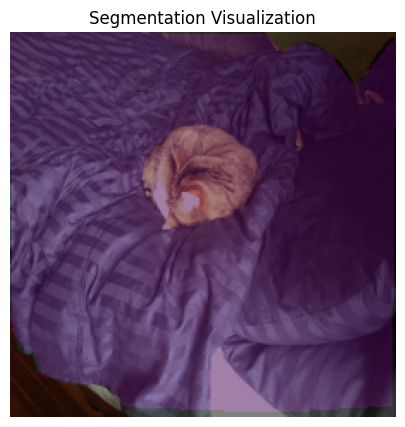

In [5]:
# Get a sample batch
sample = next(iter(train_loader))
images, masks = sample

# Extract a single image and mask
image = images[0]
mask = masks[0]

visualize_segmentation(image, mask)

In [ ]:
sample = next(iter(train_loader))
images, targets = sample

print(f"Image shape: {images[0].shape}")
print(f"Mask: {targets[0].shape}")

Image shape: torch.Size([3, 224, 224])
Annotations for the first image: torch.Size([224, 224])


#### Da qua in poi c'è da sistemare...

In [8]:
# Choose one index for visualization
idx = 0

# Forward pass through the model
x_tokens, x_cls, logits = model((images.to(device), targets.to(device)))

# Show the output
print("x_tokens: ", x_tokens.shape)
print("x_cls: ", x_cls.shape)
print("logits: ", logits.shape)

# Convert the image and privacy map to numpy arrays
image_np = sample[idx].permute(1, 2, 0).cpu().detach().numpy()

# Create a figure and axes
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Display the original image
ax.imshow(image_np)
ax.set_title("Original Image")
ax.axis('off')
plt.show()


AttributeError: 'list' object has no attribute 'to'

In [ ]:
def train(model, train_loader, num_epochs=10, learning_rate=1e-4, log_dir='./logs'):
    # Set the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # TensorBoard writer
    writer = SummaryWriter(log_dir)

    # Training loop
    model.train()

    for epoch in range(num_epochs):
        # Training phase
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Progress bar for each epoch
        with tqdm(train_loader, unit="batch") as tepoch:
            for batch_idx, (inputs, targets) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch + 1}/{num_epochs}")

                # Move inputs and targets to the device
                inputs, targets = inputs.to(device), targets.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                x_tokens, x_cls, logits = model(inputs)

                # Compute loss
                loss = criterion(logits, targets)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Track statistics
                running_loss += loss.item()
                _, predicted = torch.max(logits, 1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # Update progress bar
                accuracy = 100. * correct / total
                tepoch.set_postfix(loss=loss.item(), accuracy=accuracy)

                # Log the loss and accuracy to TensorBoard every batch
                writer.add_scalar('Training Loss', loss.item(), epoch * len(train_loader) + batch_idx)
                writer.add_scalar('Training Accuracy', accuracy, epoch * len(train_loader) + batch_idx)

        # Log the average loss and accuracy for each epoch
        avg_loss = running_loss / len(train_loader)
        epoch_accuracy = 100. * correct / total
        writer.add_scalar('Epoch Loss', avg_loss, epoch)
        writer.add_scalar('Epoch Accuracy', epoch_accuracy, epoch)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():  # Disable gradient calculation for validation
            with tqdm(val_loader, unit="batch") as vepoch:
                for batch_idx, (inputs, targets) in enumerate(vepoch):
                    vepoch.set_description(f"Validation Epoch {epoch + 1}/{num_epochs}")

                    # Move inputs and targets to the device
                    inputs, targets = inputs.to(device), targets.to(device)

                    # Forward pass
                    x_tokens, x_cls, logits = model(inputs)

                    # Compute loss
                    loss = criterion(logits, targets)
                    val_loss += loss.item()

                    # Track statistics
                    _, predicted = torch.max(logits, 1)
                    val_total += targets.size(0)
                    val_correct += predicted.eq(targets).sum().item()

                    # Update progress bar
                    val_accuracy = 100. * val_correct / val_total
                    vepoch.set_postfix(val_loss=loss.item(), val_accuracy=val_accuracy)

        # Log validation loss and accuracy for each epoch
        avg_val_loss = val_loss / len(val_loader)
        val_epoch_accuracy = 100. * val_correct / val_total
        writer.add_scalar('Validation Loss', avg_val_loss, epoch)
        writer.add_scalar('Validation Accuracy', val_epoch_accuracy, epoch)

        print(f'Validation - Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_val_loss:.4f}, Accuracy: {val_epoch_accuracy:.2f}%')

# Example call to train the model
train(model, train_loader, num_epochs=10, learning_rate=1e-2, log_dir='./logs/nascondino')


Epoch 1/10:   0%|          | 0/3697 [00:16<?, ?batch/s]


AttributeError: 'list' object has no attribute 'to'